# The overarching goal is to identify genes predictive of prognosis.  We will apply different feature selection and classification methods

Credit: The data and ideas behind these exercises and homeworks are from the breast cancer gene expression data http://www.nature.com/nature/journal/v415/n6871/full/415530a.html and http://www.nejm.org/doi/full/10.1056/NEJMoa021967#t=article.


## 1. Install Bioconductor package “breastCancerNKI”.

In [1]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install(version = "3.14")
BiocManager::install(c("breastCancerNKI", "Biobase", "impute", "class", "e1071"))
library (breastCancerNKI)
library (Biobase)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.19), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'arkhe', 'brew', 'broom', 'caret', 'class', 'classInt', 'cli',
  'codetools', 'colorspace', 'conflicted', 'covr', 'credentials', 'curl',
  'data.table', 'dbplyr', 'devtools', 'dplyr', 'DT', 'e1071', 'evaluate',
  'expm', 'fansi', 'FNN', 'fontawesome', 'forcats', 'forecast', 'fracdiff',
  'fs', 'future', 'gargle', 'gert', 'ggplot2', 'ggrepel', 'gh', 'git2r',
  'gitcreds', 'gower', 'gstat', 'gtools', 'highr', 'htmlwidgets', 'httpuv',
  'IRdisplay', 'IRkernel', 'isoband', 'janitor', 'keras', 'knitr', 'lava',
  'lhs', 'lmtest', 'lubridate', 'markdown

## 2. Explore the breast cancer data and extract training and test sets.

In [2]:
# breast cancer data object
data (nki)
# check the dimensions of the gene expression data
# there are 24481 rows (genes) across 337 patients (columns)
dim (exprs(nki))
exprs(nki)[1:5,1:5]
# check the dimensions of the phenotype data
dim (pData(nki))
pData(nki)[1:3,]
# overall survival time for each of the patient
pData(nki)$t.os[1:10]

[1] 24481   337

,NKI_4,NKI_6,NKI_7,NKI_8,NKI_9
Contig45645_RC,-0.215,0.071,0.182,-0.343,-0.134
Contig44916_RC,-0.207,0.055,0.077,0.302,0.051
D25272,-0.158,-0.010,0.059,0.169,-0.007
J00129,-0.819,-0.391,-0.624,-0.528,-0.811
Contig29982_RC,-0.267,-0.310,-0.120,-0.447,-0.536


[1] 337  21

,samplename,dataset,series,id,filename,size,age,er,grade,pgr,⋯,brca.mutation,e.dmfs,t.dmfs,node,t.rfs,e.rfs,treatment,tissue,t.os,e.os
,<chr>,<chr>,<chr>,<int>,<lgl>,<dbl>,<int>,<int>,<int>,<lgl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
NKI_4,NKI_4,NKI,NKI,4,NA,2.0,41,1,3,NA,⋯,0,0,4747,0,4747,0,0,1,4744,0
NKI_6,NKI_6,NKI,NKI,6,NA,1.3,49,1,2,NA,⋯,0,0,4075,0,4075,0,0,1,4072,0
NKI_7,NKI_7,NKI,NKI,7,NA,2.0,46,0,1,NA,⋯,0,0,3703,0,3703,0,0,1,3700,0


[1] 4744 4072 3700 3213 3757 2119 2868 2981 3005 2871

### Note there are NA's (missing values) in the survival time
Our first step is to remove patients without t.os

In [3]:
na.ind <- which (is.na(pData(nki)$t.os))
length (na.ind)
# how many patients do we have that have NA survival time

[1] 42

In [4]:
# We will now remove these 42 patients from both the gene expression 
# and phenotype data
my.data <- exprs(nki)[, -na.ind]
dim (my.data)
table (pData(nki)$series)
table (pData(nki)$series[-na.ind])
non.na.series <- pData(nki)$series[-na.ind]
table (non.na.series)
length (non.na.series)
nki.data <- my.data[, which(non.na.series == "NKI")]
dim (nki.data)
nki2.data <- my.data[, which(non.na.series == "NKI2")]
dim (nki2.data)

[1] 24481   295


 NKI NKI2 
 117  220 


 NKI NKI2 
  75  220 

non.na.series
 NKI NKI2 
  75  220 

[1] 295

[1] 24481    75

[1] 24481   220

### create the binary response variables

In [5]:
non.na.t.os <- pData(nki)$t.os[-na.ind]
length (non.na.t.os)
nki.t.os <- non.na.t.os[which(non.na.series=="NKI")]
nki2.t.os <- non.na.t.os[which(non.na.series=="NKI2")]
length (nki.t.os)
length (nki2.t.os)
nki.t.os[1:10]

[1] 295

[1] 75

[1] 220

[1] 4744 4072 3700 3213 3757 2119 2868 2981 3005 2871

In [6]:
# good prognosis = 1 when t.os >= (5 * 365)
nki.prognosis <- rep(0, length(nki.t.os))
nki.prognosis[which (nki.t.os >= (5*365))] <- 1
sum (nki.prognosis)
nki2.prognosis <- rep(0, length(nki2.t.os))
nki2.prognosis[which (nki2.t.os >= (5*365))] <- 1
sum (nki2.prognosis)
write.table (nki.prognosis, file="nki_prognosis.txt", quote=F, sep="\n", row.names=F, col.names=F)
write.table (nki2.prognosis, file="nki2_prognosis.txt", quote=F, sep="\n", row.names=F, col.names=F)

[1] 49

[1] 183

## We will build predictive models using our training data (nki.data), and test data = nki2.data

## 3. missing values
We need to remove rows and columns with lots of NA's.
We will also impute some of the missing data values.

In [7]:
any(is.na(nki.data))
any(is.na(nki2.data))

[1] TRUE

[1] TRUE

In [8]:
num.na.expt <- apply (nki.data, 2, function(x) {sum(is.na(x))})
num.na.gene <- apply (nki.data, 1, function(x) {sum(is.na(x))})
num.na.expt

NKI_4   NKI_6   NKI_7   NKI_8   NKI_9  NKI_11  NKI_12  NKI_13  NKI_14  NKI_17 
    361     305     297     295     297     297    2811     296    1472     321 
 NKI_26  NKI_27  NKI_28  NKI_29  NKI_36  NKI_38  NKI_39  NKI_45  NKI_48  NKI_51 
    324     335     337     304     302     420     312     295     297     301 
 NKI_56  NKI_57  NKI_58  NKI_59  NKI_60  NKI_61  NKI_62  NKI_71  NKI_72  NKI_73 
    302     449     306     301     303     354     298     302     298     303 
 NKI_75  NKI_76 NKI_103 NKI_107 NKI_109 NKI_110 NKI_111 NKI_113 NKI_117 NKI_118 
    303     305      23      15      15      20      11      23      22      25 
NKI_120 NKI_122 NKI_123 NKI_124 NKI_133 NKI_138 NKI_139 NKI_141 NKI_221 NKI_222 
     36      14      25      18      18      12      31      17      47      62 
NKI_224 NKI_226 NKI_227 NKI_228 NKI_229 NKI_230 NKI_231 NKI_237 NKI_238 NKI_240 
      3     141     647      29      16      21      33      33      45      25 
NKI_241 NKI_248 NKI_250 NKI_251 NKI_252 NKI_254 NKI_292 NKI_317 NKI_342 NKI_371 
     15       7      28      17      18      16      28      12      54      37 
NKI_379 NKI_380 NKI_397 NKI_398 NKI_401 
     27      34      30      15       9

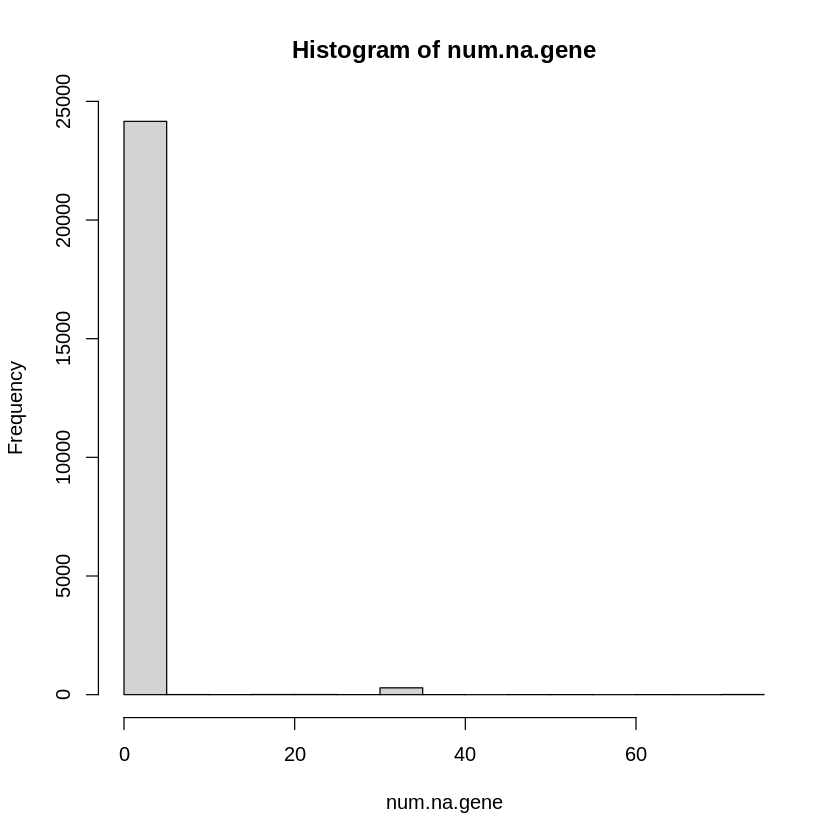

In [9]:
hist (num.na.gene)

### noticed that there are some genes with lots of missing values
### there are genes with missing values across all 75 experiments in the training data

In [10]:
max (num.na.gene)
min (num.na.gene)

[1] 75

[1] 0

### Would it make things a lot easier if we simply remove all genes with at least one missing value?

In [11]:
temp <- which (num.na.gene > 0)
length (temp)
# temp is the set of indices of genes with at least 1 missing value

[1] 4951

In [12]:
any (is.na(nki.data[-temp, ]))
any (is.na(nki2.data[-temp, ]))

[1] FALSE

[1] TRUE

### Removing genes with at least one missing value would be good for the training data
### But wouldn’t solve the missing data issue for the test set
### Looking at the distribution of “num.na.gene”. we will remove genes with >2 missing values.

In [13]:
rm.gene.ind <- which (num.na.gene > 2)
length (rm.gene.ind)
nki.data <- nki.data[-rm.gene.ind, ]
nki2.data <- nki2.data[-rm.gene.ind, ]
any (is.na(nki.data))
any (is.na(nki2.data))

[1] 428

[1] TRUE

[1] TRUE

### Now, do we have experiments with lots of missing values?

In [14]:
num.na.expt <- apply (nki.data, 2, function(x) {sum(is.na(x))})
num.na.expt

NKI_4   NKI_6   NKI_7   NKI_8   NKI_9  NKI_11  NKI_12  NKI_13  NKI_14  NKI_17 
     56       2       1       0       2       0    2471       0    1153      18 
 NKI_26  NKI_27  NKI_28  NKI_29  NKI_36  NKI_38  NKI_39  NKI_45  NKI_48  NKI_51 
     20      36      27       6       4      72       7       0       0       2 
 NKI_56  NKI_57  NKI_58  NKI_59  NKI_60  NKI_61  NKI_62  NKI_71  NKI_72  NKI_73 
      0     120       3       4       5      42       2       5       2       7 
 NKI_75  NKI_76 NKI_103 NKI_107 NKI_109 NKI_110 NKI_111 NKI_113 NKI_117 NKI_118 
      3       1       1       3       1       3       0       0       1       0 
NKI_120 NKI_122 NKI_123 NKI_124 NKI_133 NKI_138 NKI_139 NKI_141 NKI_221 NKI_222 
      0       0       2       1       0       1       0       4      21      45 
NKI_224 NKI_226 NKI_227 NKI_228 NKI_229 NKI_230 NKI_231 NKI_237 NKI_238 NKI_240 
      0      94     556       0       2       0       1       1       2       0 
NKI_241 NKI_248 NKI_250 NKI_251 NKI_252 NKI_254 NKI_292 NKI_317 NKI_342 NKI_371 
      0       1       0       0       0       0       1       0      10       2 
NKI_379 NKI_380 NKI_397 NKI_398 NKI_401 
      2       0       0       0       0

In [15]:
sum (num.na.expt > 100)

[1] 4

In [16]:
# Remove the 4 experiments with more than 100 missing values
rm.expt.ind <- which (num.na.expt > 100)
rm.expt.ind
nki.data <- nki.data[, -rm.expt.ind]
dim (nki.data)
any (is.na(nki.data))
write.table (nki.prognosis, file="nki_prognosis.txt", quote=F, sep="\n", row.names=F, col.names=F)

NKI_12  NKI_14  NKI_57 NKI_227 
      7       9      22      53

[1] 24053    71

[1] TRUE

## Missing value imputation using knn
http://www.bioconductor.org/packages/release/bioc/manuals/impute/man/impute.pdf

### Question: How to choose k in knn impute?
Reference: http://bioinformatics.oxfordjournals.org/content/17/6/520.long
Usually k=10-20 is fine.
But depends on % of missing data.
How can you evaluate performance?

### Question 1: How do you compute the % of missing data in training and test data?

In [17]:
sum (is.na(nki.data))/(nrow(nki.data) * ncol(nki.data))

[1] 0.0003080053

In [18]:
sum (is.na(nki2.data))/(nrow(nki2.data) * ncol(nki2.data))

[1] 0.003980414

In [19]:
library (impute)

In [20]:
nki.impute <- impute.knn (nki.data, k=12)

Cluster size 24053 broken into 3279 20774 
Cluster size 3279 broken into 1434 1845 
Done cluster 1434 
Cluster size 1845 broken into 232 1613 
Done cluster 232 
Cluster size 1613 broken into 675 938 
Done cluster 675 
Done cluster 938 
Done cluster 1613 
Done cluster 1845 
Done cluster 3279 
Cluster size 20774 broken into 19193 1581 
Cluster size 19193 broken into 11288 7905 
Cluster size 11288 broken into 5290 5998 
Cluster size 5290 broken into 4322 968 
Cluster size 4322 broken into 921 3401 
Done cluster 921 
Cluster size 3401 broken into 1723 1678 
Cluster size 1723 broken into 1438 285 
Done cluster 1438 
Done cluster 285 
Done cluster 1723 
Cluster size 1678 broken into 922 756 
Done cluster 922 
Done cluster 756 
Done cluster 1678 
Done cluster 3401 
Done cluster 4322 
Done cluster 968 
Done cluster 5290 
Cluster size 5998 broken into 2207 3791 
Cluster size 2207 broken into 1353 854 
Done cluster 1353 
Done cluster 854 
Done cluster 2207 
Cluster size 3791 broken into 1114 267

In [21]:
any (is.na(nki.impute$data))

[1] FALSE

In [22]:
# impute the test set
nki2.impute <- impute.knn (nki2.data, k=12)

Cluster size 24053 broken into 9161 14892 
Cluster size 9161 broken into 6884 2277 
Cluster size 6884 broken into 1005 5879 
Done cluster 1005 
Cluster size 5879 broken into 3695 2184 
Cluster size 3695 broken into 2077 1618 
Cluster size 2077 broken into 1605 472 
Cluster size 1605 broken into 82 1523 
Done cluster 82 
Cluster size 1523 broken into 1521 2 
Cluster size 1521 broken into 1034 487 
Done cluster 1034 
Done cluster 487 
Done cluster 1521 
Done cluster 2 
Done cluster 1523 
Done cluster 1605 
Done cluster 472 
Done cluster 2077 
Cluster size 1618 broken into 1039 579 
Done cluster 1039 
Done cluster 579 
Done cluster 1618 
Done cluster 3695 
Cluster size 2184 broken into 834 1350 
Done cluster 834 
Done cluster 1350 
Done cluster 2184 
Done cluster 5879 
Done cluster 6884 
Cluster size 2277 broken into 2190 87 
Cluster size 2190 broken into 624 1566 
Done cluster 624 
Cluster size 1566 broken into 1190 376 
Done cluster 1190 
Done cluster 376 
Done cluster 1566 
Done cluste

## 4. k-NN
Build predictive models using our training data (nki.data).
Test data = nki2.data
Install R package “class”.

In [23]:
library (class)

In [24]:
length (nki.prognosis)

[1] 75

In [25]:
nki.prognosis

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0
[39] 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1

In [26]:
nki.prognosis <- nki.prognosis[-rm.expt.ind]
length (nki.prognosis)

[1] 71

In [27]:
nki.prognosis

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1
[39] 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1

In [28]:
help (knn)

knn {class},R Documentation
train,matrix or data frame of training set cases.
test,matrix or data frame of test set cases. A vector will be interpreted as a row vector for a single case.
cl,factor of true classifications of training set
k,number of neighbours considered.
l,"minimum vote for definite decision, otherwise doubt. (More precisely, less than k-l dissenting votes are allowed, even if k is increased by ties.)"
prob,"If this is true, the proportion of the votes for the winning class are returned as attribute prob."
use.all,"controls handling of ties. If true, all distances equal to the kth largest are included. If false, a random selection of distances equal to the kth is chosen to use exactly k neighbours."


In [29]:
ret.knn <- knn (train=t(nki.impute$data), test=t(nki2.impute$data), cl=nki.prognosis, k=5)

In [30]:
ret.knn

[1] 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1
 [38] 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1
 [75] 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1
[112] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
[149] 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
Levels: 0 1

In [31]:
length (ret.knn)

[1] 220

In [32]:
table (ret.knn, nki2.prognosis)

       nki2.prognosis
ret.knn   0   1
      0  16  27
      1  21 156

In [33]:
(27 + 21)/220

[1] 0.2181818

#### error rate is 22%, accuracy is 78%

# Your task: to experiment with a different feature selection method, such as t.test, or correlation using a different threshold

## Idea 1: Use correlation as a univariate feature selection method
### compute the correlation of each gene vector with the class label
#### note that only the training data (nki.impute) and its labels are used

In [34]:
cor.vec <- apply (nki.impute$data, 1, function (x){cor(x, nki.prognosis)})

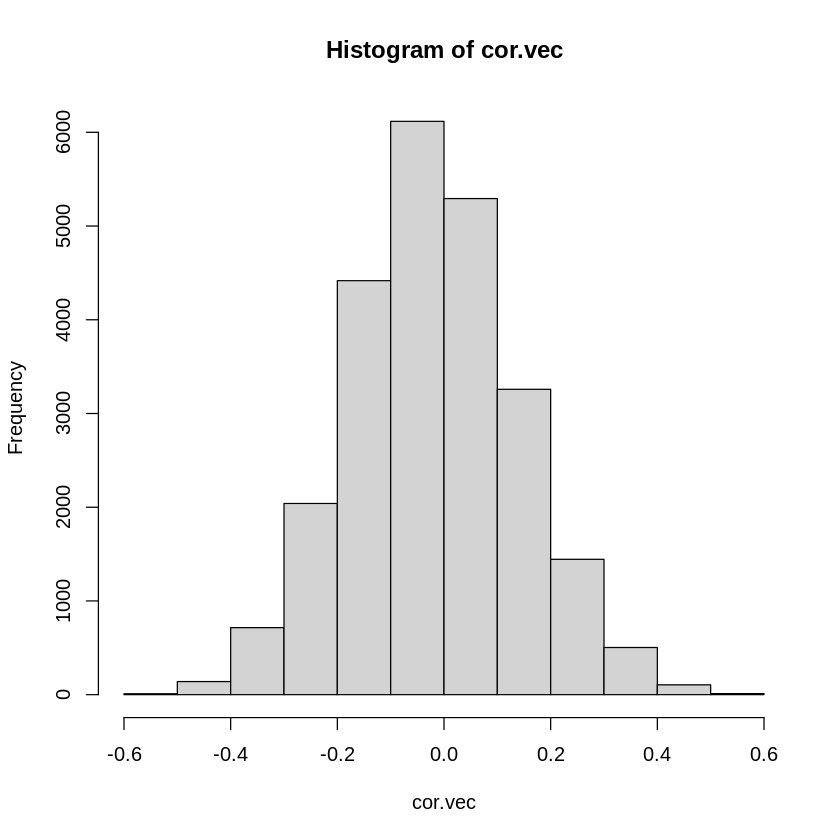

In [35]:
hist (cor.vec)

In [36]:
quantile (cor.vec, probs=c(0, 0.1, 0.25, 0.5, 0.75, 0.9, 1))

0%         10%         25%         50%         75%         90% 
-0.59586300 -0.21785292 -0.12431023 -0.02301167  0.08392453  0.18515933 
       100% 
 0.57399153

In [37]:
sum (cor.vec > 0.3)

[1] 619

In [38]:
sum (cor.vec < -0.3)

[1] 865

In [39]:
# Find the indices of genes with either very high correlation or very low correlation
gene.ind <- c(which(cor.vec > 0.3), which(cor.vec < -0.3))
length (gene.ind)

[1] 1484

In [40]:
# repeat knn using the subset of genes with high or low correlation with the class label
ret.knn2 <- knn (train=t(nki.impute$data[gene.ind, ]), test=t(nki2.impute$data[gene.ind, ]), cl=nki.prognosis, k=5)
ret.knn2

[1] 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1
 [38] 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1
 [75] 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1
[112] 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1
[149] 1 0 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1
[186] 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1
Levels: 0 1

In [41]:
table (ret.knn2, nki2.prognosis)

        nki2.prognosis
ret.knn2   0   1
       0  18  43
       1  19 140

In [42]:
# compute the percentage of error
(43 + 19)/220

[1] 0.2818182

### error rate is ~28%, which means accuracy is around 72%
### After doing extra work of feature selection, we are doing worse!

## Idea 2: Use t-test as a univariate feature selection method
### compute the t-test of each gene vector with the class label
#### note that only the training data (nki.impute) and its labels are used

In [43]:
ttest.vec <- apply (nki.impute$data, 1, function (x){(t.test(x, nki.prognosis))$p.value})

In [44]:
ttest.vec[1:10]

Contig45645_RC Contig44916_RC         D25272         J00129 Contig29982_RC 
  1.950212e-17   5.124837e-17   1.160350e-17   2.571122e-23   1.256688e-20 
   Contig26811         D25274    Contig36292    Contig42854    Contig34839 
  1.871870e-16   7.684690e-17   3.883469e-16   1.946848e-20   1.709071e-15

In [45]:
max (ttest.vec)
min (ttest.vec)

[1] 1.711156e-06

[1] 2.147879e-44

##### all the p-values are very small, let's do the Bonferroni correction for multiple comparison here

In [46]:
adj.ttest.vec <- p.adjust (ttest.vec, method="bonferroni")

In [47]:
max (adj.ttest.vec)
min (adj.ttest.vec)

[1] 0.04115843

[1] 5.166294e-40

In [48]:
sum (adj.ttest.vec < 0.05)
sum (adj.ttest.vec < 0.01)
sum (adj.ttest.vec < 0.0001)

[1] 24053

[1] 24050

[1] 24041

##### most genes show differential expression here. let's take the top 100 (with lowest p-values)

In [49]:
ret.order <- order (ttest.vec)

In [50]:
ttest.vec[ret.order[1:10]]

NM_000439      NM_004291      NM_007117      NM_001275      NM_001871 
  2.147879e-44   4.326213e-41   1.924925e-40   6.037727e-39   7.917279e-37 
     NM_001819         M33318         U22029      NM_000764 Contig24609_RC 
  3.846926e-36   4.636832e-36   6.699080e-36   7.458469e-36   5.148099e-35

In [51]:
gene.ind2 <- ret.order[1:100]
gene.ind2

[1] 20962  4384 10892 21822  2143  1935 21437   828 23252 19890  8946 11119
 [13] 17242 20232 23817 23768 21147 10481 23163 23077 20938  7948  1347    52
 [25]  9634 20182  9397  1070  7928 12032   893  3727  1270 22650  8697 15247
 [37] 22393 20127 12881 23255 23904 11021   840 18847  1216 14175  1381 16369
 [49] 16069  9585 17362 13233 22426 15394   581  5926 15818 20185   538 23816
 [61]  6284  4097 21041 10747 20892  5628  1099 14270 20909 14264  5575  8289
 [73] 10442  5079  3389 23029   616  7755  2888  4784  6283 16946   295 22505
 [85] 20263 12036  2697  9244  7535  4133 20897  1107 15966 15598 13120  8482
 [97] 19036  1092  3370  2617

In [52]:
ret.knn3 <- knn (train=t(nki.impute$data[gene.ind2, ]), test=t(nki2.impute$data[gene.ind2, ]), cl=nki.prognosis, k=5)
ret.knn3

[1] 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 1 1
 [38] 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1
 [75] 1 0 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1
[112] 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1
[149] 1 1 0 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0
[186] 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1
Levels: 0 1

In [53]:
table (ret.knn3, nki2.prognosis)

        nki2.prognosis
ret.knn3   0   1
       0  21  68
       1  16 115

In [54]:
# compute rate of error
(68+16)/220

[1] 0.3818182

### 38% error. Much worse than before!!

In [55]:
(44+16)/220

[1] 0.2727273

### 28% error similar to using correlation as the univariate feature selection method. worse than no feature selection!

Feb 22, 2023

In [56]:
# help(svm)

In [58]:
library(e1071)

In [59]:
# bukd a SVM Classifier using the imputed training data and labels of the training data
ret.svm <- svm (t(nki.impute$data), nki.prognosis)

In [60]:
#use the SCM Classifier to predict the labels in the test set
pred <- predict(ret.svm, t(nki2.impute$data))

In [61]:
table (round(pred), nki2.prognosis)

   nki2.prognosis
      0   1
  0  12  21
  1  25 162

In [62]:
(21+25)/220

[1] 0.2090909

### Using all the genes as features, SVM produces fewer errors than KNN, is doing better than KNN

## homework: try to vary arguments for the "svm" function
## Also try to run SVM using features(genes) selected using correlation or t-test.

In [63]:
BiocManager::install("randomForest")


'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.19), R 4.1.1 (2021-08-10)

Installing package(s) 'randomForest'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'arkhe', 'brew', 'broom', 'caret', 'classInt', 'cli',
  'codetools', 'colorspace', 'conflicted', 'covr', 'credentials', 'curl',
  'data.table', 'dbplyr', 'devtools', 'dplyr', 'DT', 'evaluate', 'expm',
  'fansi', 'FNN', 'fontawesome', 'forcats', 'forecast', 'fracdiff', 'fs',
  'future', 'gargle', 'gert', 'ggplot2', 'ggrepel', 'gh', 'git2r', 'gitcreds',
  'gower', 'gstat', 'gtools', 'highr', 'htmlwidgets', 'httpuv', 'IRdisplay',
  'IRkernel', 'isoband', 'janitor', 'keras', 'knitr', 'lava', 'lhs', 'lmtest',
  'lubridate', 'markdown', 'MASS', 'Matrix', 'mgcv', 'modeldata', 'nlme',
  'nloptr', 'nnet', 'parallelly', 'pbdZMQ', 'pkg

In [66]:
# build a random forest classifier using all genes in the training data
x <- cbind(t(nki.impute$data[gene.ind, ]), nki.prognosis)
ret.rf <- randomForest (as.factor (nki.prognosis) ~ ., data=x)

ERROR: Error in randomForest(as.factor(nki.prognosis) ~ ., data = x): could not find function "randomForest"


"Error in randomForest(as.factor(nki.prognosis) ~ ., data = x): could not find function "randomForest"
Traceback:" wat.
